In [3]:
# import libs && tools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
# import and handle data
df = pd.read_csv('../data/20190606180000-20190606190000.csv')
df=df.replace([np.inf, -np.inf], np.nan)
df=df.dropna();
df=df.round(decimals=5)  # round to one decimal after precision of devices
df['diff'] = (df['B_VIMIN'] - df['B:VIMIN'])
df2= pd.DataFrame({'diff' : df['diff'], 'err' : df['B:IMINER']})

# define period of TLG
horizon = 60.066; # unit: sec. horizon of TLG..61.-- sec
cycle   = 15; # 15Hz sampling
supercycle = 901; # number of time steps per supercycle (60.066 sec)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (77,79,81,83,85,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
def regulation(alpha, gamma, df):
  ## calculate the prediction with current regulation rules
  ## from Rachael's report, eq (1)
  beta=[0]
  ER = df["B:IMINER"] #error
  _MIN = df["B_VIMIN"] #setting
  for i in range(len(_MIN)):
      if i>0:
          beta_t = beta[-1] + gamma*ER[i]
          beta.append(beta_t)
  MIN_pred = _MIN - alpha * ER - beta #predict the next, shiftting happens in the plotting
  return MIN_pred

The following cell is the eq(1) from Rachael's report, showing the current regulator rules. 2 constances of alpha and gamma are currently fixed.  And we will use RL to dynamically change them. 

Text(0.5, 1.0, 'error=3.596078498985781e-05\nerror_baseline=0.0001859131191947152')

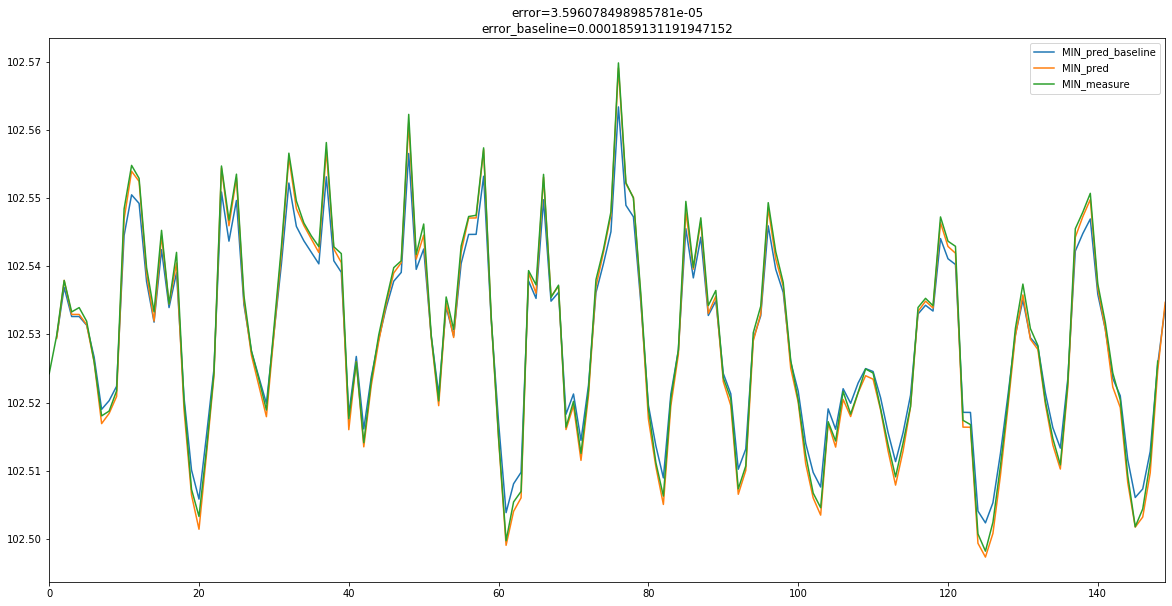

In [9]:
MIN_pred = regulation(10e-2,7.535e-5,df)
MIN_pred_baseline = regulation(8.5e-2,7.535e-5,df)

## actual measurements
MIN = df["B:VIMIN"]

## calculate error
plotLen = cycle*10#cycle = 1 sec/15 samples; supercycle = 60 cycles
error = (MIN[:plotLen-1]-MIN_pred[1:plotLen]).sem()
error_baseline=(MIN[:plotLen-1]-MIN_pred_baseline[1:plotLen]).sem()

## plotting
plt.figure(figsize=(20,10))
MIN_pred_baseline[1:plotLen].plot(label="MIN_pred_baseline")
MIN_pred[1:plotLen].plot(label="MIN_pred")
MIN[:plotLen-1].plot(label="MIN_measure")
plt.legend()
plt.title("error="+str(error)+'\n'+'error_baseline='+str(error_baseline))

In [8]:
# error comparison for the whole day is about the same
# dynamic changing of the alpha/gamma at short time period 
# cycle/supercycle would help to improve the accuracy

error_all=(MIN[:-1]-MIN_pred[1:]).sem()
error_baseline=(MIN[:-1]-MIN_pred_baseline[1:]).sem()
print (error_all)
print (error_baseline)

0.00017166752979227352
0.00016800551146635965
